# Logistic Regression

We will discuss how to build a Logistic Regression model from scratch. Then use Mini-Batch Gradient Descent to train our model.

# Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For our binary dataset
from sklearn.datasets import load_breast_cancer
import pandas as pd

# For spliting dataset
from sklearn.model_selection import train_test_split

# For Scaling Dataset
from sklearn.preprocessing import StandardScaler



## Load a Binary Dataset from `sklearn`

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target  # binary labels: 0 (malignant), 1 (benign)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# DataFrame for inspection
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Model Hypothesis

The hypothesis function is:

$$
\hat{\mathbf{y}} = \sigma(\mathbf{X} \beta)
$$

where the sigmoid function $\sigma(z)$ is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

## make prediction
$$
\hat{y} = \frac{1}{1 + e^{-z}} \quad \text{where } z = X\beta
$$

In [3]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def make_prediction(X, beta):
    """
    Logistic regression prediction: apply sigmoid to linear combination Xβ

    Args:
        X: Feature matrix of shape (N, D)
        beta: Weight vector of shape (D, 1)

    Returns:
        y_hat: Predicted probabilities, shape (N, 1)
    """
    assert X.ndim == 2, "X should be a 2D matrix"
    assert beta.ndim == 2, "beta should be a 2D column vector"
    assert X.shape[1] == beta.shape[0], \
        f"Mismatch: X has {X.shape[1]} features, but beta has {beta.shape[0]} rows"

    z = X.dot(beta)         
    y_hat = sigmoid(z)   
    return y_hat


## Convert Probabilities To Classes

Here we convert the sigmoid function out come to the two classes using a given threshold. This function applies a threshold (default = 0.5) to the predicted probabilities:

In [4]:
def convert_probabilities_to_classes(y_probs, threshold=0.5):
    """
    Convert predicted probabilities to binary class labels using np.where.

    Args:
        y_probs: Predicted probabilities (N x 1 or N,)
        threshold: Classification threshold (default is 0.5)

    Returns:
        Binary class predictions (N x 1 or N,)
    """
    return np.where(y_probs >= threshold, 1, 0)


## Compute Accuracy

In [5]:
def compute_accuracy(y_true, y_pred_probs, threshold=0.5):
    y_pred = convert_probabilities_to_classes(y_pred_probs, threshold)
    return np.mean(y_pred.flatten() == y_true.flatten())

## Compute Loss
To compute loss we use the binary cross entropy loss since it's a binary logistic regression problem. binary cross entropy loss is given as 

$$
\begin{align*}
\mathcal{L} &= -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] \\
\text{where } \hat{y}_i &= \sigma(x_i^\top \beta) = \frac{1}{1 + e^{-x_i^\top \beta}}
\end{align*}
$$


In [6]:
def binary_cross_entropy(y_true, y_pred, eps=1e-15):
    """
    Computes the binary cross-entropy loss.

    Args:
        y_true: Array of true binary labels (0 or 1), shape (N,)
        y_pred: Array of predicted probabilities, shape (N,)
        eps: Small value to avoid log(0) (default = 1e-15)

    Returns:
        Binary cross-entropy loss (scalar)
    """
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)

    # Compute binary cross entropy
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


## Computes Gradients of Loss
$$
\nabla_{\beta} \mathcal{L}= X^\top \left( \sigma(X\beta) - Y \right)
$$

In [7]:
def gradient_function(X, y, beta):
    """
    Computes gradient of binary cross-entropy loss w.r.t. beta for logistic regression

    Args:
        X: Input features (N x D)
        y: Target binary labels (N x 1)
        beta: Parameters (D x 1)

    Returns:
        Gradient (D x 1)
    """
    # Predicted probabilities (N x 1)
    y_pred = sigmoid(X @ beta)
    
    # Gradient: D x 1
    grad = X.T @ (y_pred - y)
    return grad


## The Update Rule

$$
\beta^{(t+1)} = \beta^{(t)} - \eta \nabla f(\beta^{(t)})
$$
Where:
* $\eta$ - Step size(Learning rate)
* $\nabla f(\beta^{(t)})$ - Gradient at $\beta^{(t)}$

In [8]:
def update_function(beta, grads, step_size):
  """Updates parameters with gradients
  Args:
    beta : parameters of size D x 1
    grads: gradients of size D x 1

  Returns:
    updated parameters of size D x 1
  """
  return beta - step_size*grads

## Initializes parameter beta
Here we initialize the weights with zeros

In [9]:
def initialize_beta(D):
  """Initializes parameter beta
  Args:
    D: size of parameter
  Returns:
    initial parameters of size D x 1
  """
  return np.zeros((D,1))

## Mini-Batch Gradient Descent

Mini-Batch Gradient Descent updates the weights after processing small **batches** of data, offering a balance between the computational efficiency of BGD and the faster convergence of SGD.

### **Input:**  
- Dataset: $ D = \{ (\mathbf{x}_i, y_i) \}_{i=1}^{n} $  
- Learning rate: $ \epsilon $ 
- Number of epochs  
- Batch size: $ B $
- Tolerance: `tol`

### **Output:**  
- Optimized weight vector $ \beta $

### **Algorithm:**

```text
1. Initialize β₀ = 0 ∈ ℝᵈ
2. for epoch in number of epochs do:
    3. Shuffle the dataset D
    4. Partition data into n_batches = ceil(n / B)
    5. for j = 1 to n_batches do:
        6. Get mini-batch (Xⱼ, yⱼ)
        7. Compute prediction: ŷⱼ = σ(Xⱼ β₀)
        8. Compute binary cross-entropy loss:
           L = - (1/B) ∑ [yⱼ log(ŷⱼ) + (1 − yⱼ) log(1 − ŷⱼ)]
        9. Compute gradient: ∇βL = Xⱼᵀ (ŷⱼ − yⱼ)
        10. Update weights: β₁ = β₀ − ε ∇βL
        11. if ‖β₁ − β₀‖² < tol then:
            12. break
    13. β₀ = β₁
```

In [10]:
def mini_batch_gradient_descent(X, y, lr=0.1, epochs=100, batch_size=32, tol=1e-6):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])  # Add bias term
    n, d = X_scaled.shape
    beta = initialize_beta(d)
    losses = []
    accuracies = []

    for epoch in range(epochs):
        # Shuffle data
        indices = np.arange(n)
        np.random.shuffle(indices)
        X_shuffled = X_scaled[indices]
        y_shuffled = y[indices].reshape(-1, 1)

        running_loss = 0.0

        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            y_pred = make_prediction(X_batch, beta)
            loss = binary_cross_entropy(y_batch, y_pred)
            running_loss += loss * len(y_batch)

            grad = gradient_function(X_batch, y_batch, beta)
            beta_new = update_function(beta, grad, lr)

            if np.linalg.norm(beta_new - beta) < tol:
                beta = beta_new
                break

            beta = beta_new

        # Epoch metrics
        y_full_pred = make_prediction(X_scaled, beta)
        acc = compute_accuracy(y, y_full_pred)
        epoch_loss = running_loss / n

        losses.append(epoch_loss)
        accuracies.append(acc)
        if epoch%100 ==0:
            print(f"Epoch {epoch+1:3d}: Loss = {epoch_loss:.4f}, Accuracy = {acc:.4f}")

    # Plot loss and accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses, label='Loss', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Binary Cross-Entropy Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accuracies, label='Accuracy', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Epoch   1: Loss = 0.2298, Accuracy = 0.9670
Epoch 101: Loss = 0.0489, Accuracy = 0.9868
Epoch 201: Loss = 0.0445, Accuracy = 0.9912
Epoch 301: Loss = 0.0422, Accuracy = 0.9890
Epoch 401: Loss = 0.0399, Accuracy = 0.9890
Epoch 501: Loss = 0.0386, Accuracy = 0.9890
Epoch 601: Loss = 0.0373, Accuracy = 0.9890
Epoch 701: Loss = 0.0360, Accuracy = 0.9890
Epoch 801: Loss = 0.0352, Accuracy = 0.9890
Epoch 901: Loss = 0.0344, Accuracy = 0.9890


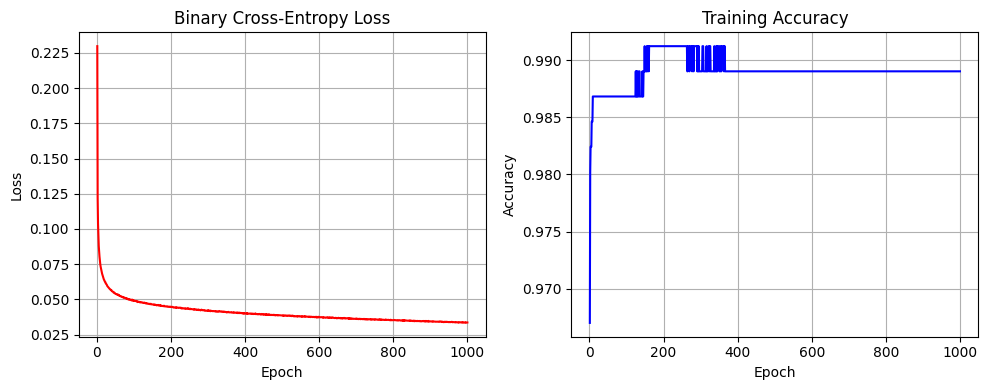

In [11]:
mini_batch_gradient_descent(X_train, y_train, lr=0.01, epochs=1000, batch_size=32)

## LogisticrRegression Class
Here we have combined all that we have discussed above in to a class. You can see the usage below


Epoch 1, Loss: 0.2465, Val Loss: 0.1755
Epoch 101, Loss: 0.0483, Val Loss: 0.0880
Epoch 201, Loss: 0.0439, Val Loss: 0.0912
Epoch 301, Loss: 0.0410, Val Loss: 0.0968
Epoch 401, Loss: 0.0392, Val Loss: 0.1019
Epoch 500, Loss: 0.0376, Val Loss: 0.1064


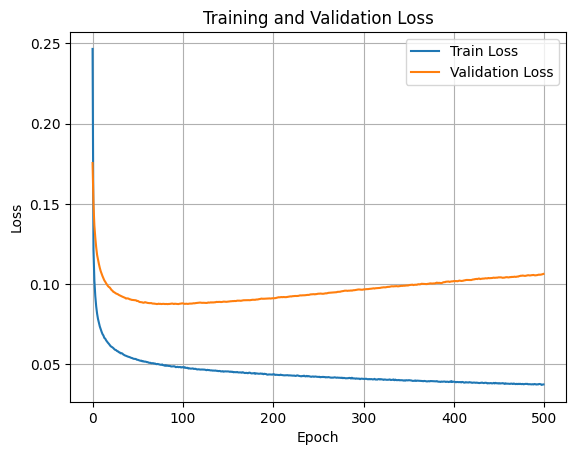

In [12]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from ek_ml_package.logistic_regression import LogisticRegression

# Initialize model
model = LogisticRegression(lr=0.01, epochs=500, batch_size=32,random_seed=123)

# Train
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
model.fit(X_scaled, y_train, validation_split=0.2)

# Predict
predictions = model.predict(X_train)

# Plot loss
model.plot_loss()